In [603]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#stationarity assumption
from statsmodels.tsa.stattools import adfuller

#trend analysis
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
pwd

'C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police'

In [4]:
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police')

In [377]:
#read in data, attempt to parse the call time date features
df = pd.read_csv('Call_Data.csv', parse_dates = [6, 7])

In [379]:
#look at some descriptive info for our dataset, looks like the date parser was unable to parse arrived_time, so I will parse that next
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170107 entries, 0 to 4170106
Data columns (total 11 columns):
CAD Event Number               int64
Event Clearance Description    object
Call Type                      object
Priority                       int64
Initial Call Type              object
Final Call Type                object
Original Time Queued           datetime64[ns]
Arrived Time                   object
Precinct                       object
Sector                         object
Beat                           object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 350.0+ MB


In [380]:
#create datetime object from arrived time
df['Arrived Time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['Arrived Time']]

In [381]:
#now I want to lowercase the entire dataframe so that there arent any capitalization error issues
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [382]:
#now I want to lowercase the columns and replace spaces with _
df.columns = [c.lower() for c in df.columns]
df.columns = [c.replace(' ', '_') for c in df.columns]

In [383]:
#now I want to look at the head of my data to make sure the changes look right
df.head(1)

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat
0,2009000189335,evidence submitted (new incident number required),"telephone other, not 911",1,dist - ip/jo - dv dist - no aslt,"--dv - arguments, disturbance (no arrest)",2009-06-02 03:35:46,2009-06-02 04:09:38,east,charlie,c1


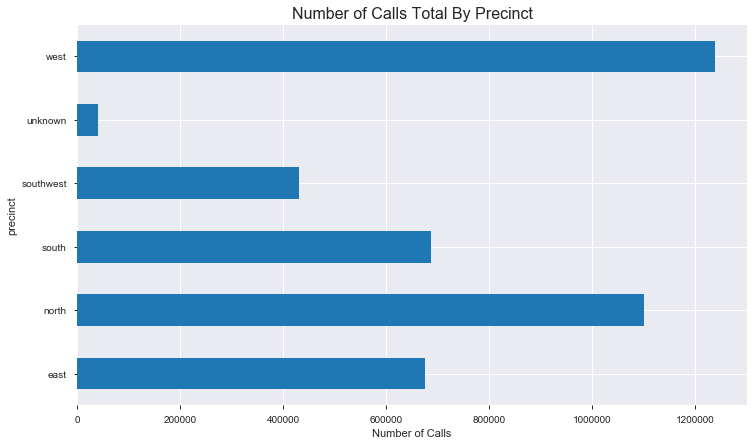

In [18]:
#how many calls are each precinct receiving in total?
df.groupby('precinct').cad_event_number.size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls Total By Precinct', fontsize = 16)
plt.xlabel('Number of Calls');

In [384]:
#I want to start with the precinct that had the most calls, so I will only be looking at data from the West precinct first
west = df[df['precinct'] == 'west']

#how much data do we have in this df?
west.shape

(1238467, 11)

In [385]:
#how many sectors and beats are in this precinct?
west.groupby(['sector', 'beat']).size()

sector  beat
david   d1      103990
        d2      116647
        d3       88081
king    k1       98693
        k2      112106
        k3      142091
mary    inv          1
        m1      103760
        m2      103996
        m3      143499
queen   q1       52862
        q2       76240
        q3       96501
dtype: int64

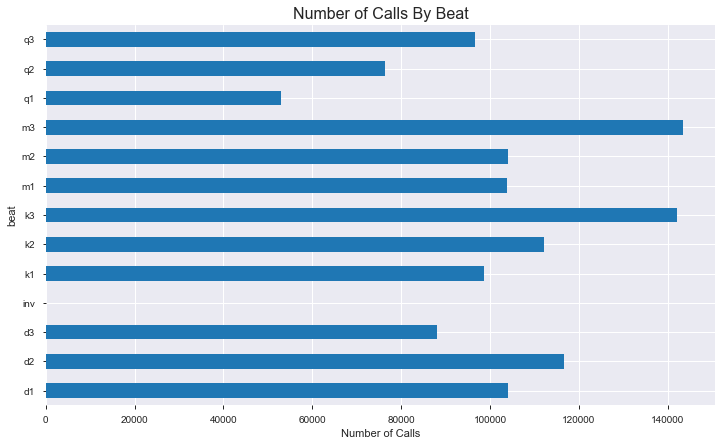

In [28]:
#plot this out to make it more interpretatble
west.groupby('beat').size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls By Beat', fontsize = 16)
plt.xlabel('Number of Calls');

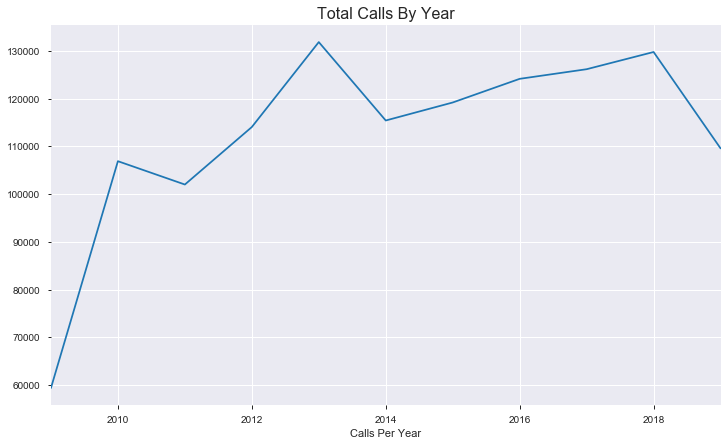

In [40]:
#looks like overall, the m3 and k3 beats have the most crimes being reported, what does call volume look like over time?
west.groupby(west['original_time_queued'].dt.year).size().plot(figsize = (12, 7))
plt.title('Total Calls By Year', fontsize = 16)
plt.xlabel('Calls Per Year');

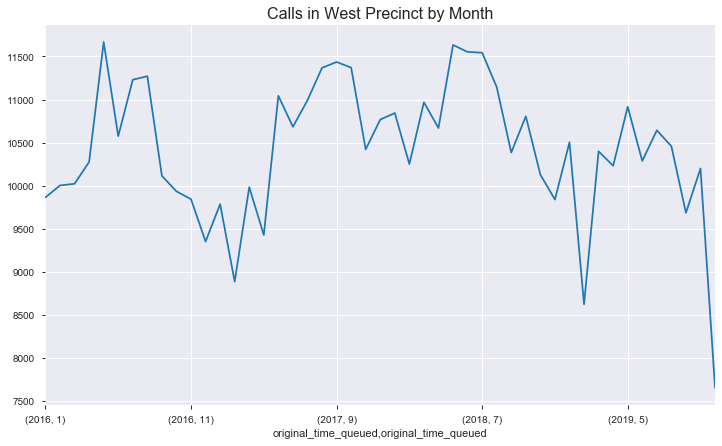

In [386]:
west[west['original_time_queued'].dt.year > 2015].groupby([west['original_time_queued'].dt.year, west['original_time_queued'].dt.month]).size().plot(figsize = (12, 7))
plt.title('Calls in West Precinct by Month', fontsize = 16);

## Now I want to model for the "King" sector in the West Precinct
- Looking at predicting call volumes by day

In [710]:
#subset west df, drop unnecessary columns
king = pd.DataFrame(west[west['sector'] == 'king'][['original_time_queued', 'cad_event_number']])
king.head()

,original_time_queued,cad_event_number
2,2009-06-02 03:47:24,2009000189340
8,2009-06-02 03:58:02,2009000189348
14,2009-06-02 04:10:17,2009000189356
28,2009-06-02 04:44:09,2009000189371
32,2009-06-02 05:00:15,2009000189375


In [711]:
#set index to datetime
king.set_index('original_time_queued', inplace = True)
king.head()

,cad_event_number
original_time_queued,
2009-06-02 03:47:24,2009000189340
2009-06-02 03:58:02,2009000189348
2009-06-02 04:10:17,2009000189356
2009-06-02 04:44:09,2009000189371
2009-06-02 05:00:15,2009000189375


In [712]:
#resample df for rollup of daily call volume
king = pd.DataFrame(king.cad_event_number.resample('d').size())
king.rename(columns = {'cad_event_number':'daily_calls'}, inplace = True)
king.head()

,daily_calls
original_time_queued,
2009-06-02,95
2009-06-03,106
2009-06-04,94
2009-06-05,94
2009-06-06,69


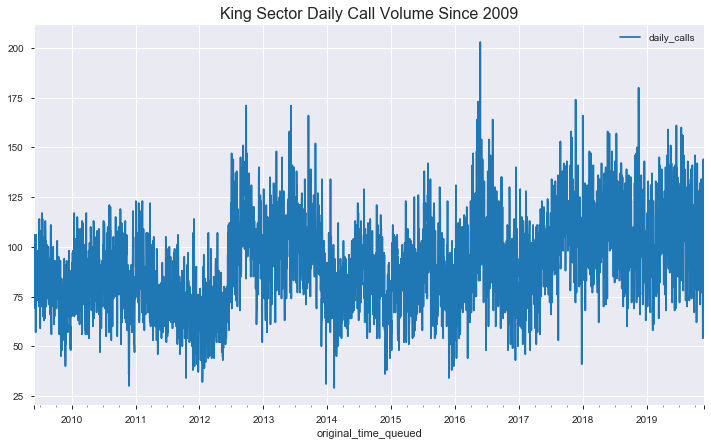

In [403]:
#plot out daily calls for d1 beat in west precinct, looks like the daily calls have been trending down overall, with a spike in 2012
king.plot(figsize = (12, 7))
plt.title('King Sector Daily Call Volume Since 2009', fontsize = 16);

__Rolling Means__
- Now I want to look at plotting the data vs a "rolling mean", which is just the average of whatever window size that you specify
- I am going to play around with several different window sizes to find a good fit for the data

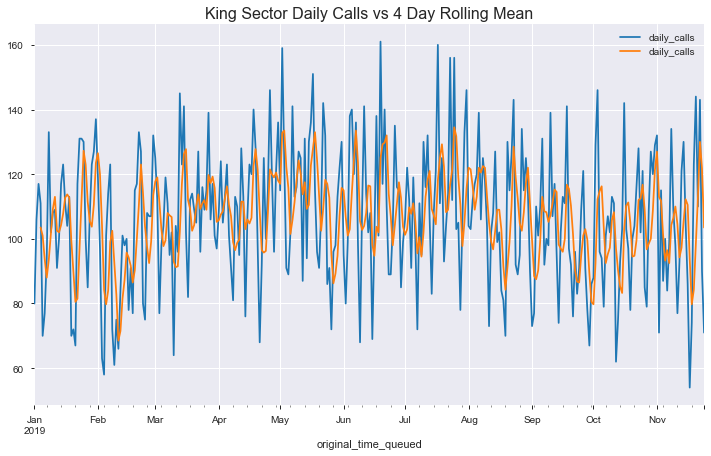

In [713]:
#now look at only data for 2019
king_2019 = king.loc['2019-01-01':, :]

#now plot that data against a rolling mean with a window size of 
king_2019.plot(legend = True, figsize = (12, 7))
plt.title('King Sector Daily Calls vs 4 Day Rolling Mean', fontsize = 16)

#we can make the window ANY size
king_2019.rolling(window = 4).mean()['daily_calls'].plot(legend = True);

__Outlier Removal__
- Removing outliers can increase the quality of a model's predictions significantly, so I will do this and plot the rolling mean again as well

In [714]:

def z_score_indices_of_outliers(X, threshold=3):
    '''
    Detects outliers using Z-score standardization
    
    Input: - X: A feature in your dataset
           - threshold: The number of standard deviations from the mean
                        to be considered an outlier
                        
    Output: A data frame with all outliers beyond 3 standard deviations
    '''
    X_mean = np.mean(X)
    X_stdev = np.std(X)
    z_scores = [(y - X_mean) / X_stdev for y in X]
    z_df = pd.DataFrame(z_scores)
    pos_outliers = z_df[z_df[0] > 3]
    neg_outliers = z_df[z_df[0] < -3]
    return pos_outliers; neg_outliers

In [715]:
#detect outliers
to_drop = z_score_indices_of_outliers(king_2019['daily_calls'], 3)

#remove outliers 
king_2019 = king_2019.reset_index().drop(to_drop.index).set_index('original_time_queued')

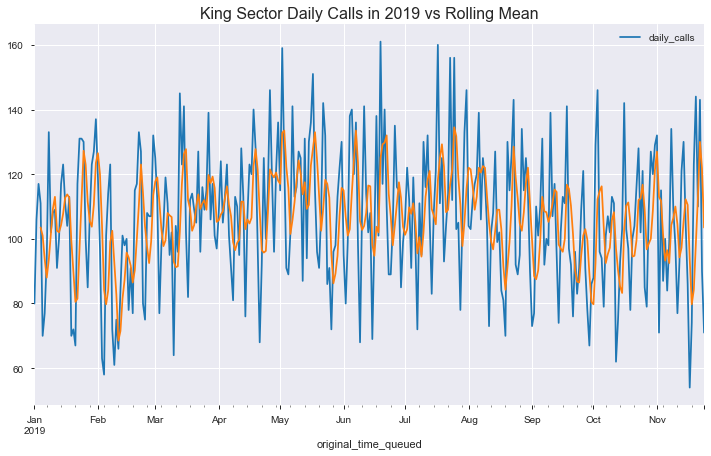

In [716]:
#now plot that data against a rolling mean with a window size of 4 days
king_2019.plot(figsize = (12, 7))
plt.title('King Sector Daily Calls in 2019 vs Rolling Mean', fontsize = 16)

#plot rolling mean, we can see that the rolling mean fits the data a little better than it did with the outliers in place
king_2019.rolling(window = 4).mean()['daily_calls'].plot();

__Finding Overall Trends__
- I am going to use the hodrick-prescott filter to find the overall trend for this beat's call volume
- you can set the filter for windows of data, I am going to use quarterly (by setting lambda value)

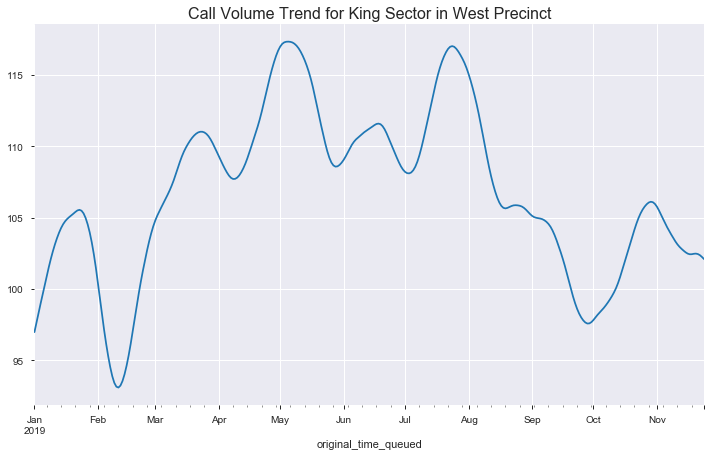

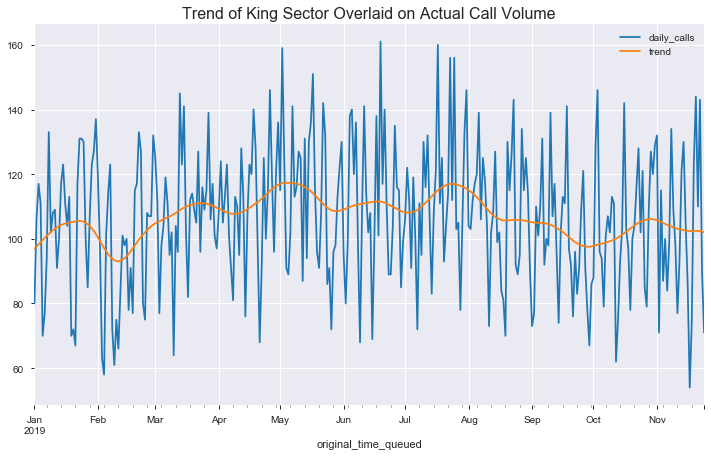

In [717]:
#use statsmodels to get the trend (hodrick-prescott filter)
# tuple unpacking gdp_cycle, gdp_trend
call_cycle, call_trend = hpfilter(king_2019.daily_calls, lamb = 1600)

call_trend.plot(figsize = (12, 7))
plt.title('Call Volume Trend for King Sector in West Precinct', fontsize = 16)

#add trend column to d1_2019 so that we can plot the trend on top of the df
king_2019['trend'] = call_trend

#plot the trend over the data
king_2019[['daily_calls', 'trend']].plot(figsize = (12, 7))
plt.title('Trend of King Sector Overlaid on Actual Call Volume', fontsize = 16);

__ETS Decomposition (Error, Trend, Seasonality)__
- decomposing the data into these subplots shows that there is some seasonality to the data

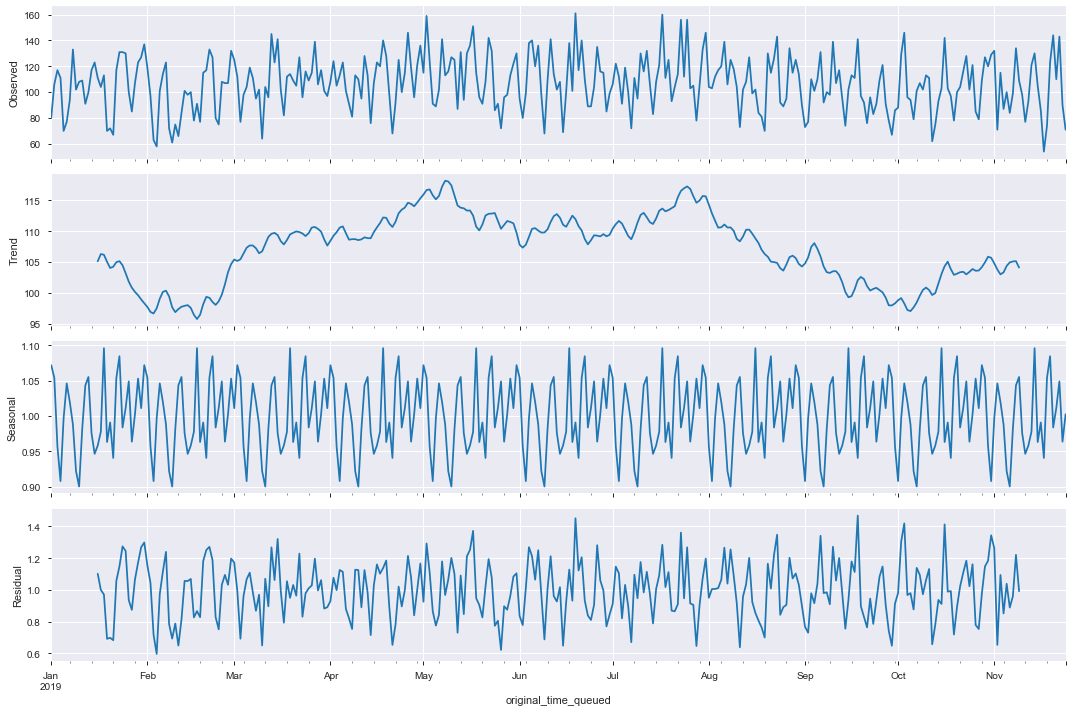

In [718]:
#this is basically separating our data into three different facets, error/seasonality/trend, so we can call those three things as if they are methods of the 
# multiplicative model
results = seasonal_decompose(king_2019['daily_calls'], model = 'multiplicative', freq = 30)

#make plot larger
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10 #specify figsize

results.plot(); #we have to put the ; after the plot for some reason, its weird without it

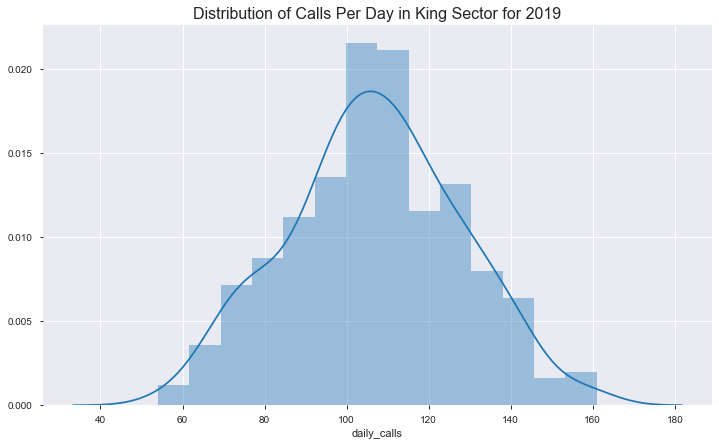

In [784]:
#check to see if the distribution of the residuals is normal, this would be ideal for modeling, it seems as though the data is close to normally distributed
plt.figure(figsize = (12, 7))
sns.distplot(king_2019['daily_calls'])
plt.title('Distribution of Calls Per Day in King Sector for 2019', fontsize = 16);

## Forecasting with the Holt-Winters Method
- I am going to use exponential smoothing to forecast and see if its better than the AR or ARMA models that I have created thus far

## Double Exponential Smoothing

In [744]:
#explicitly make training data a 'double' type, which is the only type of data that exponential smoothing seems to take
king_2019 = king_2019.astype('double')

king_2019['DESmul12'] = ExponentialSmoothing(king_2019['daily_calls'], trend='mul', seasonal_periods = 4).fit().fittedvalues.shift(-1)
king_2019.head()

,daily_calls,trend,DESmul12
original_time_queued,,,
2019-01-01,80.00,96.97,80.19
2019-01-02,106.00,97.65,88.47
2019-01-03,117.00,98.31,98.78
2019-01-04,111.00,98.96,101.51
2019-01-05,70.00,99.61,82.49


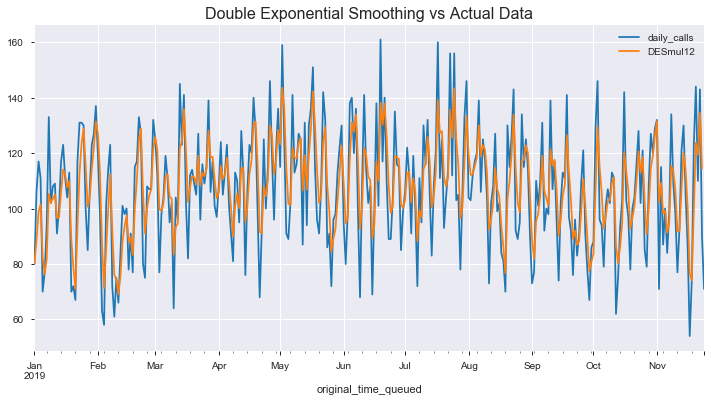

In [745]:
king_2019[['daily_calls','DESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
plt.title('Double Exponential Smoothing vs Actual Data', fontsize = 16);

___
## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [746]:
king_2019['TESmul12'] = ExponentialSmoothing(king_2019['daily_calls'],trend='mul',seasonal='mul',seasonal_periods=70).fit().fittedvalues
king_2019.head()

,daily_calls,trend,DESmul12,TESmul12
original_time_queued,,,,
2019-01-01,80.00,96.97,80.19,80.13
2019-01-02,106.00,97.65,88.47,106.33
2019-01-03,117.00,98.31,98.78,117.54
2019-01-04,111.00,98.96,101.51,111.66
2019-01-05,70.00,99.61,82.49,70.51


In [747]:
# df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
# df.head()

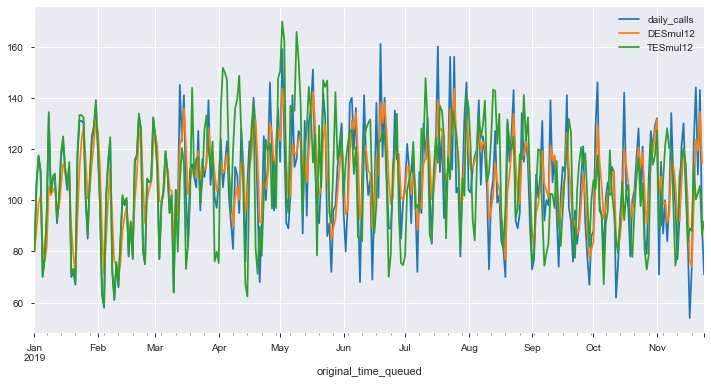

In [748]:
king_2019[['daily_calls','DESmul12', 'TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

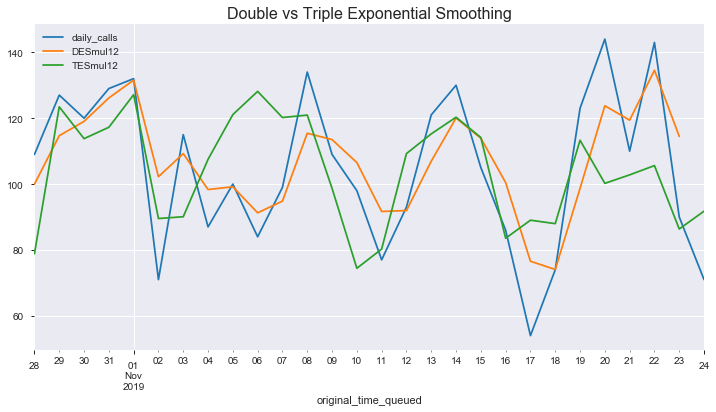

In [767]:
king_2019[['daily_calls','DESmul12','TESmul12']].iloc[300:].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
plt.title('Double vs Triple Exponential Smoothing', fontsize = 16);

__Evaluate The Model__

In [739]:
#explicitly make training data a 'double' type, which is the only type of data that exponential smoothing seems to take
train = train.astype('double')

#fit the model (I tweaked seasonal_perdiods quite a bit to look for the most accurate models and landed on 70, curious since it should be 7)
fitted_model = ExponentialSmoothing(train['daily_calls'],trend='mul',seasonal='mul',seasonal_periods=70).fit()

In [740]:
#forecast
test_predictions = fitted_model.forecast(27).rename('HW Forecast')

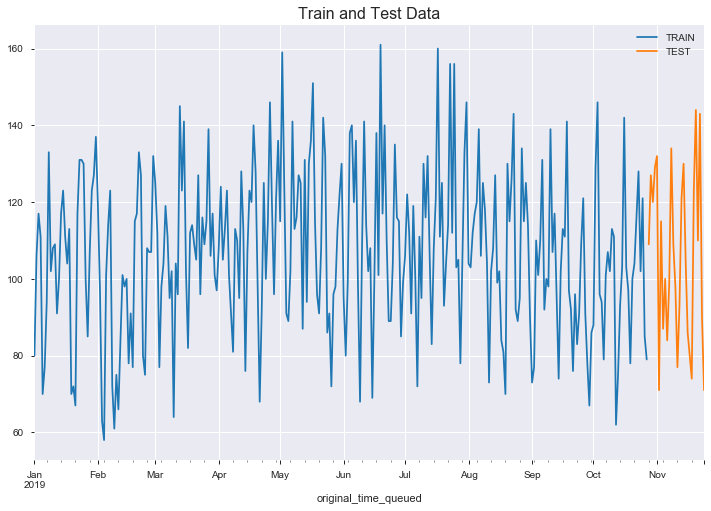

In [741]:
train['daily_calls'].plot(legend=True,label='TRAIN')
test['daily_calls'].plot(legend=True,label='TEST',figsize=(12,8))
plt.title('Train and Test Data', fontsize = 16);

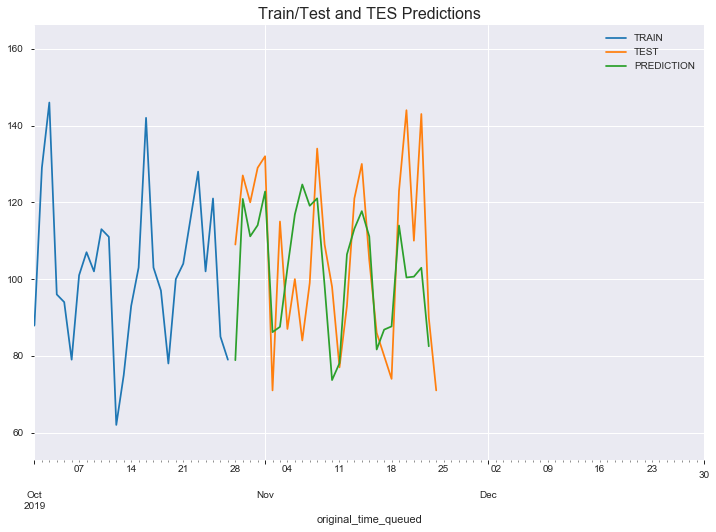

In [781]:
train['daily_calls'].plot(legend=True,label='TRAIN')
test['daily_calls'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train/Test and TES Predictions', fontsize= 16)
plt.xlim('2019-10-01', '2019-12-30');

In [782]:
#evaluate Model
print(f'RMSE of Triple Exponential Smoothing: {np.sqrt(mean_squared_error(test,test_predictions))} Calls Per Day')

RMSE of Triple Exponential Smoothing: 19.937088750914594 Calls Per Day


## Modeling with Autoregression (ARIMA without the integrated moving average) 
- I want to see if these models will perform better than exponential smoothing

__Is this data stationary?__
- I am going to use the augmented dickey-fuller test to determine if the data is in need of differencing to create stationarity
- stationary data is needed for quality predictions in time series modeling

In [719]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [720]:
adf_test(king_2019['daily_calls'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.11
p-value                  0.03
# lags used             13.00
# observations         314.00
critical value (1%)     -3.45
critical value (5%)     -2.87
critical value (10%)    -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [723]:
#split the data in train/test sets
# Set one month for testing
train = king_2019[['daily_calls']].iloc[:300]
test = king_2019[['daily_calls']].iloc[300:]

## Fit an AR(p) model where statsmodels chooses p
we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [724]:
model = AR(train['daily_calls'])

#allow statsmodels to choose the maxlag parameter for us rather than iterating through options
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 16
Coefficients:
const             46.81
L1.daily_calls     0.18
L2.daily_calls     0.10
L3.daily_calls    -0.08
L4.daily_calls     0.03
L5.daily_calls     0.02
L6.daily_calls     0.16
L7.daily_calls     0.15
L8.daily_calls    -0.05
L9.daily_calls    -0.05
L10.daily_calls   -0.05
L11.daily_calls   -0.06
L12.daily_calls   -0.09
L13.daily_calls    0.01
L14.daily_calls    0.32
L15.daily_calls    0.06
L16.daily_calls   -0.09
dtype: float64


In [725]:
#obtaining predictions from the model with a window of aroudn 25 days at the end of the data for testing
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions16 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

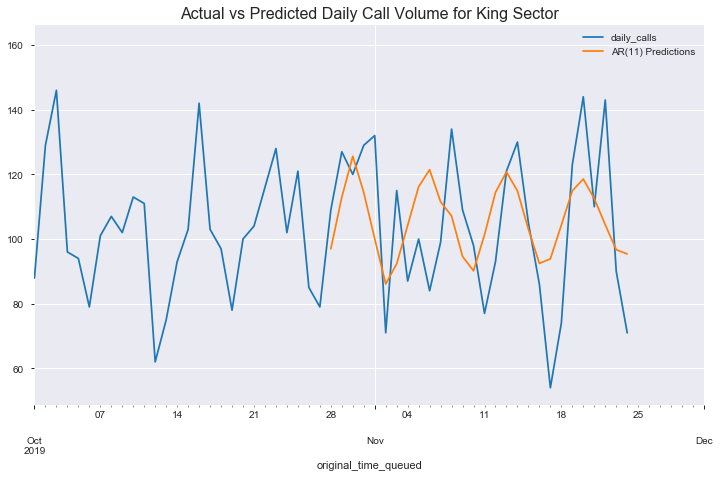

In [726]:
#plot the predictions
king_2019['daily_calls'].plot(legend = True)
predictions16.plot(legend = True, figsize = (12, 7))
plt.title('Actual vs Predicted Daily Call Volume for King Sector', fontsize = 16)
plt.xlim('2019-10-01', '2019-12-01');

## Evaluate the Model's Performance
- I am going to use RMSE to get error terms in the units of the original variable, which is calls per day

In [727]:
#compare multiple models with this code
# labels = ['AR(11)']
# preds = [predictions16] 

# for i in range(1):
#     error = np.sqrt(mean_squared_error(test['daily_calls'], preds[i]))
#     print(f'{labels[i]} Error: {error:11.10}')

print(f"Autoregression Model RMSE: {np.sqrt(mean_squared_error(test['daily_calls'], predictions16))} Calls Per Day")

Autoregression Model RMSE: 20.818338470846285 Calls Per Day


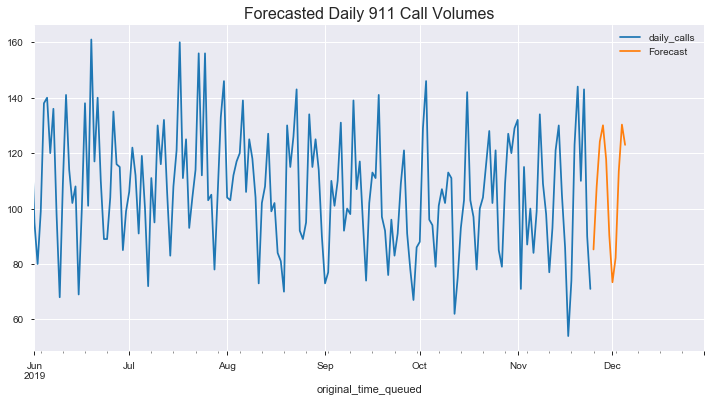

In [773]:
#predict future calls with model now
# First, retrain the model on the full dataset
model = AR(king_2019['daily_calls'])

# Next, fit the model
ARfit = model.fit(maxlag=16,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(king_2019), end=len(king_2019)+10, dynamic=False).rename('Forecast')

# Plot the results
king_2019['daily_calls'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6))
plt.title('Forecasted Daily 911 Call Volumes', fontsize = 16)
plt.xlim('2019-06-01', '2019-12-30');

In [729]:
fcast

2019-11-25    85.24
2019-11-26   107.89
2019-11-27   124.19
2019-11-28   130.04
2019-11-29   117.83
2019-11-30    90.40
2019-12-01    73.40
2019-12-02    82.22
2019-12-03   113.43
2019-12-04   130.30
2019-12-05   122.98
Freq: D, Name: Forecast, dtype: float64

## ARMA Modeling
- Since we were getting ok predictions with an AR model, I am now going to add in a moving average (MA) component to see if the prediction quality can improve

### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [730]:
auto_arima(king_2019['daily_calls'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  328
Model:                     ARMA(2, 4)   Log Likelihood               -1389.782
Method:                       css-mle   S.D. of innovations             16.539
Date:                Fri, 27 Dec 2019   AIC                           2795.565
Time:                        14:52:10   BIC                           2825.909
Sample:                             0   HQIC                          2807.671
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6849      1.113     95.850      0.000     104.503     108.866
ar.L1.y        1.2458      0.002    712.905      0.000       1.242       1.249
ar.L2.y       -1.0000      0.000  -3582.140      0.000      -1.001      -0.999
ma.L1.y       -1.1131      0.059    -18.880      0.000      -1.229      -0.998
ma.L2.y        0.9217      0.088     10.479      0.000       0.749       1.094
ma.L3.y        0.0199      0.081      0.247      0.805      -0.138       0.178
ma.L4.y        0.0912      0.053      1.730      0.085      -0.012       0.195
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6229           -0.7823j            1.0000           -0.1430
AR.2            0.6229           +0.7823j            1.0000            0.1430
MA.1            0.6251           -0.7820j            1.0011           -0.1427
MA.2            0.6251           +0.7820j            1.0011            0.1427
MA.3           -0.7345           -3.2252j            3.3077           -0.2856
MA.4           -0.7345           +3.2252j            3.3077            0.2856
-----------------------------------------------------------------------------
"""

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being returned.

In [731]:
model = ARMA(train['daily_calls'],order=(2,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            daily_calls   No. Observations:                  300
Model:                     ARMA(2, 4)   Log Likelihood               -1265.274
Method:                       css-mle   S.D. of innovations             16.189
Date:                Fri, 27 Dec 2019   AIC                           2546.547
Time:                        14:52:15   BIC                           2576.178
Sample:                    01-01-2019   HQIC                          2558.405
                         - 10-27-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               106.8731      1.149     92.976      0.000     104.620     109.126
ar.L1.daily_calls     1.2443      0.002    686.782      0.000       1.241       1.248
ar.L2.daily_calls    -0.9999      0.000  -2553.797      0.000      -1.001      -0.999
ma.L1.daily_calls    -1.1181      0.060    -18.680      0.000      -1.235      -1.001
ma.L2.daily_calls     0.9435      0.090     10.431      0.000       0.766       1.121
ma.L3.daily_calls    -0.0042      0.085     -0.049      0.961      -0.172       0.163
ma.L4.daily_calls     0.1089      0.053      2.052      0.041       0.005       0.213
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6222           -0.7829j            1.0000           -0.1431
AR.2            0.6222           +0.7829j            1.0000            0.1431
MA.1            0.6253           -0.7806j            1.0002           -0.1425
MA.2            0.6253           +0.7806j            1.0002            0.1425
MA.3           -0.6060           -2.9686j            3.0299           -0.2820
MA.4           -0.6060           +2.9686j            3.0299            0.2820
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [732]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,4) Predictions')

### Plot predictions against known values
- could  be useful to look into taking out another round of outliers to see impact on model

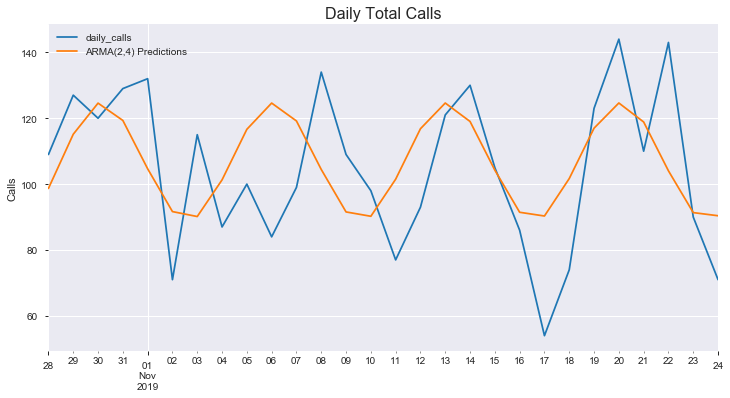

In [733]:
title = 'Daily Total Calls'
ylabel='Calls'
xlabel='' # we don't really need a label here

ax = test['daily_calls'].plot(legend=True,figsize=(12,6))
plt.title(title, fontsize = 16)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [734]:
def z_score_outliers(x, threshold):
    
    '''returns index of outliers and their values as zip object
    arguments: column of dataframe as x, threshold of standard deviations (typically 3) as z-score threshold
    '''
    import numpy as np
    from scipy import stats
    z = np.abs(stats.zscore(x))
    outliers = x[z > threshold]
    outliers_index = x[z > threshold].index
    outlier_pairs = zip(outliers_index, outliers)
    return [print(x) for x in outlier_pairs]

In [735]:
z_score_outliers(test['daily_calls'], 2)

(Timestamp('2019-11-17 00:00:00'), 54)


[None]

In [736]:
#drop this outlier
test.drop(test[test['daily_calls'] < 55].index, inplace = True)

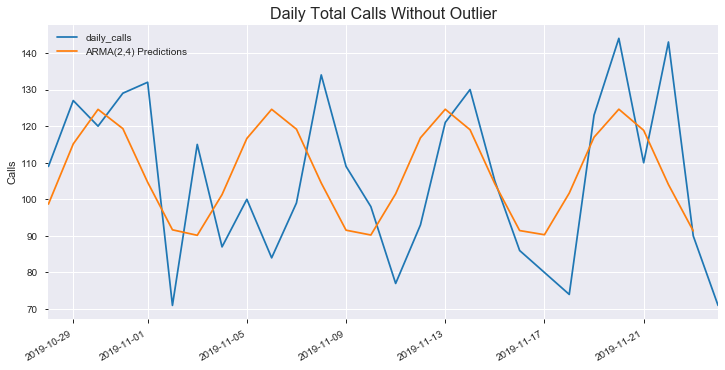

In [737]:
#get new predictions and re-plot
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,4) Predictions')

#plot predictions against known values
title = 'Daily Total Calls Without Outlier'
ylabel='Calls'
xlabel='' # we don't really need a label here

ax = test['daily_calls'].plot(legend=True,figsize=(12,6))
plt.title(title, fontsize = 16)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [738]:
#get new RMSE for ARMA model, slightly better than exponential smoothing
print(f"ARMA Model RMSE: {np.sqrt(mean_squared_error(test['daily_calls'], predictions))} Calls Per Day")

ARMA Model RMSE: 19.35635547124751 Calls Per Day


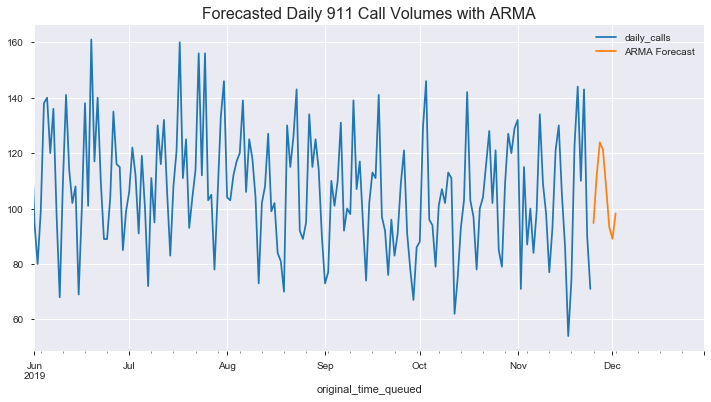

In [779]:
#create future predicted values
#predict future calls with model now
# First, retrain the model on the full dataset
ARMA_model = ARMA(king_2019['daily_calls'],order=(2,4))
ARMAfit = ARMA_model.fit()

# Make predictions for next week
ARMA_fcast = ARMAfit.predict(start=len(king_2019), end=len(king_2019)+7, dynamic=False).rename('ARMA Forecast')

# Plot the results
king_2019['daily_calls'].plot(legend=True)
ARMA_fcast.plot(legend=True,figsize=(12,6))
plt.title('Forecasted Daily 911 Call Volumes with ARMA', fontsize = 16)
plt.xlim('2019-06-01', '2019-12-30');

In [780]:
#predictions
ARMA_fcast

2019-11-25    94.77
2019-11-26   111.75
2019-11-27   123.89
2019-11-28   121.18
2019-11-29   107.54
2019-11-30    93.26
2019-12-01    89.10
2019-12-02    98.21
Freq: D, Name: ARMA Forecast, dtype: float64